*****************************************************************
#  Benford’s law for analysis friend network in VK
*****************************************************************

The project was carried out within the course 'Social Web'. Methodology is based on the Jennifer Golbeck research on the application of Benford's Law to social metrics in online networks (Golbeck,2015).

This notebook is intended for demonstration of the code only. Descriptive and result parts are presented in the report.

All code was run on the Python 3.8

In [1]:
# packages installing
!pip install vk_api matplotlib scipy
# let's also import everything right away
import vk_api
import json
import random
import csv
import sys
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import chisquare
from numpy import polyfit, polyval
from requests import ConnectionError

## Part 1: Data collecting

For our research, we decided to collect numbers of friends of users on the Russian social web [VK](https://vk.com/). We were using VK API - [documentation](https://vk.com/dev.php?method=methods).

### 1.1 Creating a session
There are at least 2 ways of creating a session with VK API:
1. Use credentials of your account (not an app, just a login and a password of a registered user)
2. Create an app on [this page](https://vk.com/apps?act=manage) and use its credentials

In [ ]:
# using your account login and password
vk_session = vk_api.VkApi("login", "password")
vk_session.auth()
vk = vk_session.get_api()

# # using credentials of your app
# # The procedure of receiving code is described here - https://vk.com/dev/authcode_flow_user, paragraph 1
# code = 'code'
# redirect_url = 'http://example.com/verify'
# app = 'appid'
# secret = 'secret'
# vk_session = vk_api.VkApi(app_id=app, client_secret=secret)
# vk = vk_session.code_auth(code, redirect_url)
# vk_session.code_auth(code, redirect_url)
# vk = vk_session.get_api()

print(vk)

### 1.2: Using VK API methods
Here are examples of two methods that were used for data retrieving.
1. [friends.get](https://vk.com/dev/friends.get) returns a list of the user's friend IDs or extended information about the user's friends, included count. So with it user's count of friends and all friends IDs were retrieved
2. [users.get](https://vk.com/dev/users.get) returns extended information about users. It allows us to get a count of friends even if an account is private - with 'fields' attribute. Also, VK API limits the number of requests for methods (not in general), so using two methods increases the number of requests that can be done.

In [ ]:
# example of used API methods
user_friends_info = vk.friends.get(user_id=27109751) # this is my account and I fully agree to provide its information 👌
print("Information about friends")
print(user_friends_info)
some_friend = vk.users.get(user_id=user_friends_info['items'][10], fields="counters")
print("Some friend count")
print(some_friend[0]['counters']['friends'])

The following code was used to collect data. 
- Main part is a loop that goes through a range between ID = 1000 and ID = 100000000. Step is 10000, so for one run the loop try to get around 10000 users ((100000000 - 1000) / 10000). 
- For each iteration, it takes a random number - test_uset and checks if it is possible to take his friends IDs and if his number of friends is between 150 and 5000. The lower bound, 150, is explained by a sufficient sample to apply Benford's law. The upper one, 5000, [features](https://vk.com/dev/friends.get) of the VK API, by default it does not give out more than 5000 and we decided to completely exclude such users. 
- Then, if the user passes filters there is another loop - for each of his friends we're collecting the count of his friends
- Some users are deactivated (can be deleted or banned) and the count of their friends is not accessible. IDs of such users go to 'damaged_ids'
- Results are loaded to 'collected_VK_users_{timestamp}.json' file
- 'existing_users.csv' was created to avoid users duplicating since it was decided to run this cycle several times

In [ ]:
# out = time.time()  # file versioning

# # initializing dictonary to collect data
# VK_users_info = {}

# # getting id of already collected users
# ex_users = []
# with open('existing_users.csv') as f:
#     reader = csv.reader(f)
#     for row in reader:
#         ex_users.append(int(row[0]))

# # retrieving users information
# for i in range(1000, 100000000, 10000):
        
#     test_user = random.randint(i, i+10000)
#     while test_user in ex_users:
#         test_user = random.randint(i, i + 10000)
#     print(f'Working with {test_user}')
#     try:
#         user_id = vk.friends.get(user_id=test_user)  # getting user's friends info if possible
#         if 150 < user_id['count'] < 5000:            # filter by friends count
#             print(f"User {test_user} was accepted")
#             with open('existing_users.csv', 'a', newline='') as outfile:
#                 writer = csv.writer(outfile)
#                 writer.writerow([test_user])
#             VK_users_info[test_user] = {}
#             VK_users_info[test_user]['ff_count'] = []
#             VK_users_info[test_user]['damaged_ids'] = []
#             VK_users_info[test_user]['f_ids'] = user_id['items']
#             VK_users_info[test_user]['f_count'] = user_id['count']
#             print(f"User {test_user} has {user_id['count']} friends")
#             print(f"User {test_user} friends ids {user_id['items']}")

#             # friends bypass to get their friends count
#             for friend in user_id['items']:
#                 try:
#                     f_info = vk.users.get(user_id=friend, fields="counters")
#                     if f_info[0].get('deactivated') is not None:
#                         VK_users_info[test_user]['damaged_ids'].append(friend)
#                     else:
#                         VK_users_info[test_user]['ff_count'].append(f_info[0]['counters']['friends'])
#                 except ConnectionError as e:
#                     print(f"New error for friend {friend}")
#                     print(e)
#                 except:
#                     print(f"Error for {friend} friend id")
#                     print(sys.exc_info()[0])
#             with open(f"collected_VK_users_{out}.json", 'w') as outfile:
#                 json.dump(VK_users_info, outfile)
#         else:
#             print(f"User {test_user} does not have required number of friends")
#     except vk_api.ApiError as e:
#         if e.code == 29: # Error 29 stands for rate limit exceeded. There is no point in further requests, that is why we interrupt executing the program
#             print(f"{e.error['error_msg']}")
#             exit(29)
#         else:
#             print(f"{e.code}: {e.error['error_msg']}")
#     except:
#         print(f"User {test_user} was rejected")
#         print(sys.exc_info()[0])
#     break

After performing the code above three times we've got 3 files: "collected_VK_users_1607192220.2532628.json", "collected_VK_users_1607514086.6058345.json", "collected_VK_users_1607751717.0215929.json". The following code was used to merge them in one file that was further used for all analysis - "collected_VK_users.json"

In [ ]:
# def json_summ(a, b):
#     c = {}
#     for k, v in a.items():
#         c[k] = v
#     for k, v in b.items():
#         if c.get(k) is None:
#             c[k] = v
#     return c


# files = ["collected_VK_users_1607192220.2532628.json", "collected_VK_users_1607514086.6058345.json", "collected_VK_users_1607751717.0215929.json"]

# summ = {}
# for file in files:
#     with open(file) as f:
#         b = json.load(f)
#     print(f"Number of keys in {file} is {len(b)}")
#     summ = json_summ(summ, b)

# print(f"Number of keys in summary file is {len(summ)}\n")
# with open("collected_VK_users.json", 'w') as outfile:
#     json.dump(summ, outfile)

### 1.3: Example of extracted user data
- 'ff_count' stands for the list of counts of friends for all user's friends
- 'f_count' shows the number of friends of the analyzed account
- In order not to violate the privacy of users, after the entire analysis, the data was anonymized. All IDs in "collected_VK_users.json" were deleted. The "exsisting.csv" file was also deleted. Comparing with Benford's law is still possible, but there is no way to find a user in the social network to check his page. So, for demonstration, only anonymized data is available.

In [2]:
# # anonymized with
# with open("collected_VK_users.json") as file:
#     vk_users_dict = json.load(file)
# anon_data = {}
# for i, el in enumerate(vk_users_dict.values()):
#     anon_data[f"user_{i}"] = {
#         "ff_count": el["ff_count"],
#         "f_count": el["f_count"]
#     }
# with open("collected_VK_users.json", 'w') as outfile:
#     json.dump(anon_data, outfile)

# example of retrieved data
with open('collected_VK_users.json') as jf:
    vk_users_dict = json.load(jf)
print("Example of data for some user")
print(vk_users_dict['user_42'])

Example of data for some user
{'ff_count': [3408, 9771, 7745, 1853, 1404, 1107, 535, 147, 247, 207, 421, 297, 217, 509, 327, 165, 322, 296, 1796, 337, 82, 248, 5430, 558, 369, 196, 326, 267, 171, 1259, 365, 392, 1093, 183, 1245, 2428, 446, 282, 1494, 230, 4595, 438, 436, 334, 171, 154, 346, 9069, 153, 181, 298, 280, 416, 1026, 320, 102, 355, 168, 238, 502, 661, 132, 120, 213, 147, 360, 405, 210, 598, 99, 86, 123, 918, 184, 815, 4437, 675, 249, 191, 1010, 8436, 3217, 625, 296, 557, 251, 393, 319, 173, 235, 9538, 120, 781, 696, 192, 228, 308, 563, 7703, 2679, 534, 406, 266, 298, 94, 585, 126, 908, 164, 225, 769, 902, 875, 394, 395, 2403, 2186, 2761, 253, 277, 1067, 5856, 46, 483, 508, 351, 1925, 267, 943, 239, 210, 226, 330, 557, 252, 327, 255, 756, 266, 715, 362, 120, 35, 399, 9887, 324, 517, 149, 335, 1061, 182, 96, 131, 444, 285, 8882, 700, 165, 811, 1372, 359, 484, 108, 4457, 209, 91, 567, 1046, 902, 223, 187, 4034, 402, 435, 265, 520, 241, 187, 83, 197, 7966, 77, 203, 615, 118, 351,


## 2: General sample statistic
First, some general metrics of the preserved dataset were analyzed. To get some overall view of data we're working with before comparing with Benford's law. Started with the size.

In [3]:
with open("collected_VK_users.json") as file:
    vk_users_dict = json.load(file)

print(f"Data sample has {len(vk_users_dict.keys())} accounts for analysis")

Data sample has 2357 accounts for analysis


### 2.1: Number of friends
We took a number of friends for each account in the dataset to check what is the distribution of these counts.
- Average (in other words, mean) for friends number is higher than median and means the data is shifted to the left. This is confirmed by the plot 
- Plot shows that almost all accounts in the dataset have less than 1000 friends and there is a significant number of accounts with less than 500 friends
- Min and max values comply with filters conditions

Average: 423.5150615188799
Median: 276
Max: 4725
Min: 151


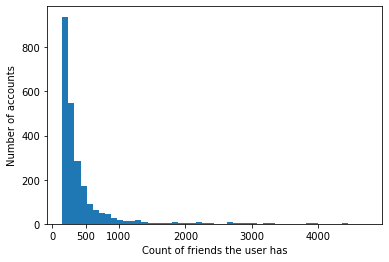

In [4]:
# analyze diversity of number of friends
freinds_count = []
for user in vk_users_dict.items():
    freinds_count.append(user[1]['f_count'])
freinds_count.sort()
print(f'Average: {sum(freinds_count) / len(freinds_count)}')
print(f'Median: {freinds_count[round(len(freinds_count) / 2)]}')
print(f'Max: {freinds_count[len(freinds_count) - 1]}')
print(f'Min: {freinds_count[0]}')

plt.hist(freinds_count, bins = 50)
plt.xticks([0, 500, 1000, 2000, 3000, 4000])
plt.ylabel("Number of accounts")
plt.xlabel("Count of friends the user has")
plt.show()

### 2.2: Proportion of deactivated friends
As it was mentioned user can have a deactivated account as a friend. Deactivated users don't have a number of friends, which might affect the sample so its distribution won't fit Benford's law. We decided to examine the proportion of deactivated users for each account in the dataset. 
- Average (in other words, mean) for the proportion of deactivated users is also higher than median and again means the data is shifted to the left. This is confirmed by the plot
- Also median value - 10 - means that half of the dataset has less than 10% of deactivated users

Average proportion of deactivated accounts: 0.12084898715046834
Median proportion of deactivated accounts: 0.10230179028132991
Max proportion of deactivated accounts: 0.8119402985074626
Min proportion of deactivated accounts: 0.0 

Statistic for proportion of deactivated friends for all users

25.84% of users has less than 5% of deactivated friends
49.38% of users has less than 10% of deactivated friends
69.03% of users has less than 15% of deactivated friends
84.34% of users has less than 20% of deactivated friends
91.56% of users has less than 25% of deactivated friends
95.21% of users has less than 30% of deactivated friends


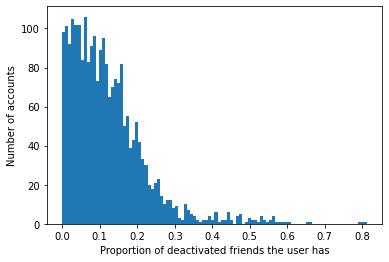

In [5]:
# analyze percentage of damaged users
damaged_percentage = []
for user in vk_users_dict.items():
    damaged_percentage.append(1 - len(user[1]['ff_count']) / user[1]['f_count'])
damaged_percentage.sort()
print(f'Average proportion of deactivated accounts: {sum(damaged_percentage) / len(damaged_percentage)}')
print(f'Median proportion of deactivated accounts: {damaged_percentage[round(len(damaged_percentage) / 2)]}')
print(f'Max proportion of deactivated accounts: {damaged_percentage[len(damaged_percentage) - 1]}')
print(f'Min proportion of deactivated accounts: {damaged_percentage[0]} \n')

print(f'Statistic for proportion of deactivated friends for all users\n')

for proportion in range(5, 31, 5):
    print(f'{sum(1 for i in damaged_percentage if i < (proportion/100)) * 100 / len(damaged_percentage):.2f}% of users \
has less than {proportion}% of deactivated friends')

plt.hist(damaged_percentage, bins = 100)
plt.ylabel("Number of accounts")
plt.xlabel("Proportion of deactivated friends the user has")
plt.show()

### 2.3: Diversity of orders of magnitude
Benford's law is more suitable for analyzing data samples that cover several orders of magnitude (in other words, that have good digits number diversity). For example, if there are only numbers between 100 and 999 - all numbers have only 3 digits - it is a bad coverage of orders of magnitude (or bad digits number diversity).
For this analysis, we took not only the number of friends of accounts but also the number of friends of friends, all the counts within our data sample.
Results shown in the plot demonstrates that our data has sufficient coverage of orders of magnitude (or digits number diversity), although it could've been more diverse. Most friends count is 3-digit numbers.

Digits diversity
0-digit numbers percentage: 0.04%
1-digit numbers percentage: 0.98%
2-digit numbers percentage: 12.17%
3-digit numbers percentage: 60.44%
4-digit numbers percentage: 26.32%
5-digit numbers percentage: 0.05%


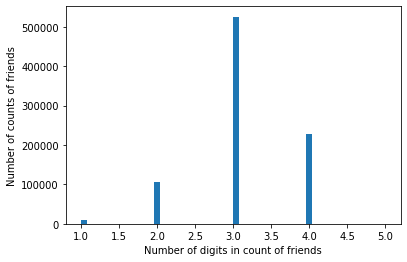

In [6]:
# analyze digits number diversity
digit_frequency = []
frequency = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for user in vk_users_dict.items():
    for count in user[1]['ff_count']:
        digit_frequency.append(len(str(count)))
        if count != 0:
            frequency[len(str(count))] += 1
        else:
            frequency[0] += 1

frequency_percentage = {k: v/sum(frequency.values()) for (k, v) in frequency.items()}

print("Digits diversity")
for item in frequency_percentage.items():
    print(f"{item[0]}-digit numbers percentage: {item[1] * 100:.2f}%")
plt.hist(digit_frequency, bins = 50)
plt.ylabel("Number of counts of friends")
plt.xlabel("Number of digits in count of friends")
plt.show()

## Part 3: Benford's law application
Benford's law distribution formula is P$(d)$ = log<sub>10</sub>(1 + $\frac{1}{d}$). Distribution values are in expected_frequencies variable in percent form. To check fitting to Benford's law we needed to compare observed frequencies and empirical frequencies of Benford's law

### 3.1: Checking for fitting Benford's law
- Function compare_bl takes a list of numbers that were collected as input. This list must be null-free. 
- For each number in the provided list we take its first digit and increase the corresponding counter in the digit_counts list. (for digit "1" corresponding counter will be digit_counts\[0\], for "2" digit_counts\[1\] since list are numbered from zero).
- Observed frequencies are obtained by dividing the counter value by the sum of all counters values and further multiplying to 100, to get percent form. 
- Comparing observed and expected frequencies is performed by chisquare test from scipy.stats. It returns chi-squared test statistic and p-value.

In [10]:
# passed list suppose not to have zeros
def compare_bl(analyzed_list):
    digit_counts = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    expected_frequencies = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]
    for count in analyzed_list:
        digit_counts[int(str(count)[:1]) - 1] += 1
    observed_frequencies = [100 * count/sum(digit_counts) for count in digit_counts]

    chi, pv = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)
    return {"distribution": observed_frequencies, "tests": (chi, pv)}

### 3.2: Visualization of comparison to Benford's law
To see if distributions comply their plots can be displayed with the plot_compare_bl function. It takes a list of frequencies distribution in percent form as input. Then, the function places it with Benford's law distribution on the same plot.

In [11]:
# passed list suppose to have frequencies of leading dgigits in percentage
def plot_compare_bl(empirical_frequencies):
    expected_frequencies = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]
    fig, ax = plt.subplots()
    ax.bar(range(1, 10), empirical_frequencies, color="#dddddd")
    ax.plot(range(1, 10), empirical_frequencies, color="#aaaaaa", linewidth=2, label="Observed distribution")
    ax.plot(range(1, 10), expected_frequencies, color="blue", linewidth=4, label="Benford's law distribution")
    plt.xticks(range(1,10))
    plt.ylabel("Frequency, %")
    plt.xlabel("Leading digits")
    plt.legend()
    plt.show()

# # random distribution to check
# plot_compare_bl([31.32, 22.68, 12.0, 9.66, 8.34, 4.67, 3.35, 3.35, 4.67])

### 3.3: Applying Benford's law to the dataset
The next step is to compare the data sample of each account with Benford's law. It was decided to put the results of this process in a separate file - "results_VK_users.json". Such a file will allow many different manipulations with results for further analysis. In this file we went over all accounts and performed the following operations:
- Remove zeroes from ff_count list and place results to analyzed_list variable
- Add f_count to analyzed_list variable
- Preserve the proportion of not deactivated friends ('eligible_users_percentage')
- Preserve the dictionary depicted the coverage of orders of magnitude ('digits_diversity')
- Run compare_bl function on analyzed_list and save the results - 'observed_distribtion', 'chisquare_value', 'p-value'

In [12]:
users_stat = {}

for user in vk_users_dict.items():
        analyzed_list = list(filter(lambda a: a != 0, user[1]['ff_count']))  # remove zeroes
        analyzed_list.append(len(analyzed_list))
        users_stat[user[0]] = {}
        users_stat[user[0]]['friends_count'] = len(analyzed_list) - 1
        users_stat[user[0]]['eligible_users_percentage'] = (len(analyzed_list) - 1) / user[1]['f_count']
        frequency = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
        for count in user[1]['ff_count']:
            frequency[len(str(count))] += 1
        users_stat[user[0]]['digits_diversity'] = {k: v / sum(frequency.values()) for (k, v) in frequency.items()}
        results = compare_bl(analyzed_list)
        users_stat[user[0]]['observed_distribtion'] = results["distribution"]
        users_stat[user[0]]['chisquare_value'] = results["tests"][0]
        users_stat[user[0]]['p-value'] = results["tests"][1]
        
# with open("results_VK_users.json", 'w') as outfile:
#     json.dump(users_stat, outfile)

### 3.4: Displaying some examples
The degree of similarity with Benford's law is determined by the p-value. The higher p-value is the more observed sample fits Benford's law. Samples that have p-value less than 0.05 will be considered as ones that are breaking Benford's law.
Complying with Benford's law also can be visually shown on plots. As for the two examples below. The first one complies with Benford's law (p-value > 0.99), the second one does not comply with Benford's law (p-value < 0.05). It is confirmed with plots on which blue line depicts Benford's law and grey one - observed frequencies.

Account, complying with Benford's law
{'friends_count': 696, 'eligible_users_percentage': 0.7204968944099379, 'digits_diversity': {1: 0.16522988505747127, 2: 0.2988505747126437, 3: 0.37787356321839083, 4: 0.15804597701149425, 5: 0.0}, 'observed_distribtion': [31.70731707317073, 17.50358680057389, 11.908177905308465, 9.038737446197992, 7.890961262553802, 6.025824964131994, 6.312769010043041, 4.734576757532281, 4.878048780487805], 'chisquare_value': 0.31562812062084356, 'p-value': 0.999977213016651}


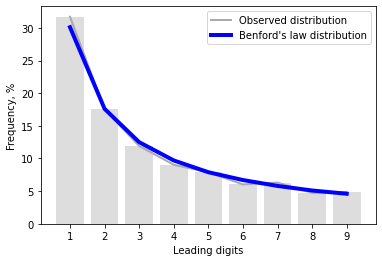

Account, breaking Benford's law
{'friends_count': 413, 'eligible_users_percentage': 0.921875, 'digits_diversity': {1: 0.0, 2: 0.01694915254237288, 3: 0.18159806295399517, 4: 0.7917675544794189, 5: 0.009685230024213076}, 'observed_distribtion': [15.458937198067632, 11.594202898550725, 14.009661835748792, 8.93719806763285, 8.93719806763285, 10.38647342995169, 10.144927536231885, 8.21256038647343, 12.318840579710145], 'chisquare_value': 29.68467843771147, 'p-value': 0.0002402906548809726}


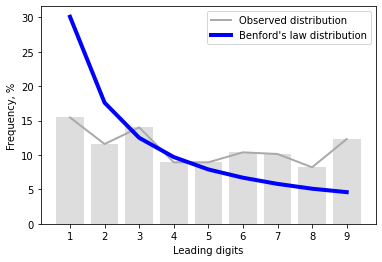

In [13]:
# account, complying with Benford's law 
print("Account, complying with Benford's law")
print(users_stat["user_169"])
plot_compare_bl(users_stat["user_169"]["observed_distribtion"])

# account, breaking Benford's law
print("Account, breaking Benford's law")
print(users_stat["user_1109"])
plot_compare_bl(users_stat["user_1109"]["observed_distribtion"])

## Part 4: Further analysis and results
All further analysis was performed on data in "results_VK_users.json". We tried to understand how different account properties (number of friends, digits number diversity) can affect fitting Benford's law. Also, one theory of user behavior was checked (section 4.4). All analysis was performed only for accounts that have less than 15% of deactivated friends ("eligible_users_percentage" > 0.85). This condition decreases data sample to 1626 accounts among which 67 do not comply with Benford's law (about 4%).

In [ ]:
with open("results_VK_users.json") as file:
    user_stat = json.load(file)

print(f"Number of accounts to analyze: {sum(1 for i in user_stat.values() if i['eligible_users_percentage'] > 0.85)}")
print(f"Number of accounts that are not comply with Benford's law: \
{sum(1 for i in user_stat.values() if i['eligible_users_percentage'] > 0.85 and i['p-value'] < 0.05)}")

### 4.1: P-value and number of friends
First, we decided to find out if there is a pattern between p-values and the number of friends a user has. For this purpose, the plot below was made. It has a logarithmic scale on the x-axis since most of our users have less than 1000 friends. No significant pattern was found. Accounts with friends between 150 and 1000 have all range of p-values. Accounts with a number of friends more than 1000 have different p-values too, but most of their p-values higher than 0.6.

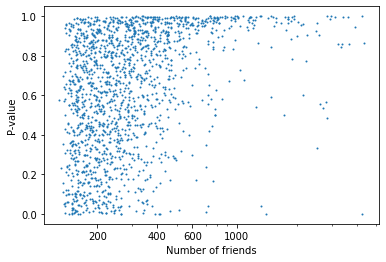

In [14]:
filtered_users_stat = {k: v for k, v in users_stat.items() if v["eligible_users_percentage"] > 0.85} # pick accounts that have less than 15% of deactivated friends
fig, ax = plt.subplots() # init graph
p_values = [v["p-value"] for v in filtered_users_stat.values()] # extract p-values from picked accounts
friends_counts = [v["friends_count"] for v in filtered_users_stat.values()] # extract number of friends from picked accounts
ax.plot(friends_counts, p_values, 'o', markersize=1) # mark the values on the graph, where x - number of friends and y - p-values
plt.xscale("log") # use logarithmic scale
plt.xlabel("Number of friends") # label the x-axis
plt.ylabel("P-value") # label the y-axis
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter()) # make ticks not tied to logarithmic values
plt.xticks([200, 400, 600, 1000]) # set the locations of ticks on the x-axis
plt.show() # show graph

### 4.2: Breaking Benford's law accounts and their number of friends
It was also decided to compare the proportion of accounts that break Benford's law and the number of friends they have. For this purpose, the plot below was made, but no significant pattern was found. Peaks after 1000 friends can be explained by an insufficient number of accounts in the displayed interval. Before we enter the cycle we set the values of the step, which points out for what number of friends we will move the range, and the maximum value of the range that will be increased with each iteration. On each iteration, we pick those users whose number of friends falls in the specified range, e.g. \[0; 100) or \[100; 200). Among those users we look for anomalies, that is, those users, whose p-value is less than 0.05. As the final step, we calculate the proportion between the number of anomalies and users in the current subsample. After the cycle, we plot and show the graph.

In [ ]:
filtered_users_stat = {k: v for k, v in users_stat.items() if v["eligible_users_percentage"] > 0.85} # pick accounts that have less than 15% of deactivated friends
step = current_maximum = 100 # init the values
anomalies_count = [] # init the array
while current_maximum < 5001: # enter the cycle, we will leave it when our range will be above 5000 friends. Our dataset doen not contain such users
    users = {k: v for k, v in filtered_users_stat.items() if (current_maximum - step) < v["friends_count"] < current_maximum} # pick users that have specified number of friends
    anomalies = {k: v for k, v in users.items() if v["p-value"] < 0.05} # pick anomalies from those users
    if len(users) != 0: # check if we found any
        anomalies_count.append(len(anomalies) / len(users)) # add a proportion
    else:
        anomalies_count.append(0.0) # escape division by zero, add zero, beacuse there are no anomalies
    current_maximum += step # increase the maximum by step
fig, ax = plt.subplots() # init graph
ax.plot(range(step, 5001, step), anomalies_count) # plot the values
plt.xlabel("Count of friends the user has") # label the x-axis
plt.ylabel("Proportion of breaking Benford's law accounts") # label the y-axis
plt.xticks(range(step, 5001, 600)) # set the locations of ticks on the x-axis
plt.show() # show graph

### 4.3: Breaking Benford's law accounts and their diversity of orders of magnitude
Observed distribution may not fit Benford's law if the coverage of order of magnitude is not sufficient. To check it on our sample the plot below was made. For each account, we took the difference between the most frequent digit and the second frequent digit in "digits_diversity". For example, for dictionary "digits_diversity": {"1": 0.023411371237458192,"2": 0.2809364548494983,"3": 0.6454849498327759,"4": 0.05016722408026756,"5": 0.0} the difference will be 0,6454849498327759 - 0,2809364548494983 = **0,3645484949832776**. To some extent, we can assume that the bigger difference is the fewer digit numbers diversity is. Such account's differences and their p-value are shown in the plot.
Also, the approximation line was added to the plot and it shows that the more difference between the top highest frequencies of digits numbers the less is p-value. Or, in other words, the fewer digits number diversity is the less distribution complies with Benford's law.

In [ ]:
filtered_users_stat = {k: v for k, v in users_stat.items() if v["eligible_users_percentage"] > 0.85} # pick accounts that have less than 15% of deactivated friends
p_values = [v["p-value"] for v in filtered_users_stat.values()] # extract p-values from picked accounts
diversities = [v["digits_diversity"] for v in filtered_users_stat.values()] # extract diversity dictionaries from picked accounts
maximums = [max(diversity.values()) for diversity in diversities] # extract maximum from each diversity dictionary
diversities_without_maximums = [{k: v for k, v in el[0].items() if v != el[1]} for el in zip(diversities, maximums)] # form new list of diversity dictionaries with removing the maximum value found on previous step from corresponding dictionary
second_maximums = [max(diversity.values()) for diversity in diversities_without_maximums] # extract maximum from each new formed diversity dictionary, that is, diversity dictionary without already found maximum value
diff = [el[0] - el[1] for el in zip(maximums, second_maximums)] # form a list of differences between the most frequent and second frequent digit
fig, ax = plt.subplots() # init graph
ax.plot(diff, p_values, 'o', markersize=1) # plot the values, where x - difference, y - p-value

pairs = [(el[0], el[1]) for el in zip(diff, p_values)] # form a list of pairs (difference, p-value)
pairs.sort(key=lambda pair: pair[0]) # sort the list by p-value ascending
x = [pair[0] for pair in pairs] # extract differences as x
y = [pair[1] for pair in pairs] # extract p-values as y
a, b = polyfit(x, y, 1) # find coefficient of a and b 
y_pred = polyval([a, b], x) # predict y-values on a corresponding line
ax.plot(x, y_pred, 'r') # plot the line

plt.xlabel("Difference between max and second_max diverse digit") # label the x-axis
plt.ylabel("P-value") # label the y-axis
plt.show() # show graph

### 4.4: Number of followers to the number of friends
Additionally, during the manual examination of accounts that break Benford's law, we noticed that in many cases the number of followers exceeds the number of friends. It can happen if a user recently "cleaned up" his account - unfriend users he is not in contact with anymore. We decide to figure out if there is a pattern that accounts that break Benford's law has more followers than friends while accounts that comply with whit Benford's law doesn't.
For 67 (number of accounts that break Benford's law) users with the highest p-value and 67 users with the lowest p-value number of followers and friends was retrieved.
The red line in the plot demonstrates the ratio of followers to friends for users that break Benford's law. The green line in the plot demonstrates the ratio of followers to friends for users that comply with Benford's law. Although there are high peaks for both groups, the average value shows that for accounts breaking Benford's law case of having more followers than friends is more spread.
This test is not repeatable since data was anonymized. The image of the plot is posted in the end of the notebook and included in the archive (Plot.png).

In [ ]:
# def follow_friend_proportion(user_ids):
#     # getting count of user's friends and followers from VK
#     counters, errors = vk_api.vk_request_one_param_pool( # we call a library function
#         vk_session, # we pass it already initiated session object
#         "users.get", # we pass it a name of the method that we would like to call
#         key="user_id", # we pass it a parameter that will change
#         values=user_ids, # we pass it a list of variables
#         default_values={"fields": "counters"} # and we also pass it values that do not change, but must be present with each request
#     )
#     proportion_list = [] 
#     for k, v in counters.items(): # from each user we extract
#         followers = v[0]["counters"]["followers"] # number of followers
#         friends = v[0]["counters"]["friends"] # number of friends
#         proportion_list.append(followers/friends) # calculate the proportion
#     return proportion_list

# with open("results_VK_users.json") as file:
#     user_stat = json.load(file)

# filtered_users_stat = {k: v for k, v in users_stat.items() if v["eligible_users_percentage"] > 0.85}
# number_to_select = 67
# users = sorted(iter(filtered_users_stat), key=lambda user: filtered_users_stat[user]["p-value"]) # we sort the users that we picked by their p-value ascending
# high_p_value = users[-number_to_select:] # high p-value users will be in the end of the list
# low_p_value = users[:number_to_select] # low p-value users will be in the beginning of it

# high_p_value_proportion = follow_friend_proportion(high_p_value)
# low_p_value_proportion = follow_friend_proportion(low_p_value)

# print(f"Average for users with a high p-value is {sum(high_p_value_proportion) / number_to_select}")
# print(f"Average for users with a low p-value is {sum(low_p_value_proportion) / number_to_select}")

# fig, ax = plt.subplots()
# ax.plot(range(number_to_select), high_p_value_proportion, color='green', label="Users with highest p-value")
# ax.plot(range(number_to_select), low_p_value_proportion, color='red', label="Users with lowest p-value")
# plt.xlabel("Users sorted according to p-value ascending")
# plt.ylabel("Proportion of followers to friends")
# plt.legend() # add a graph legend according to labels of the plotted lines
# plt.show()

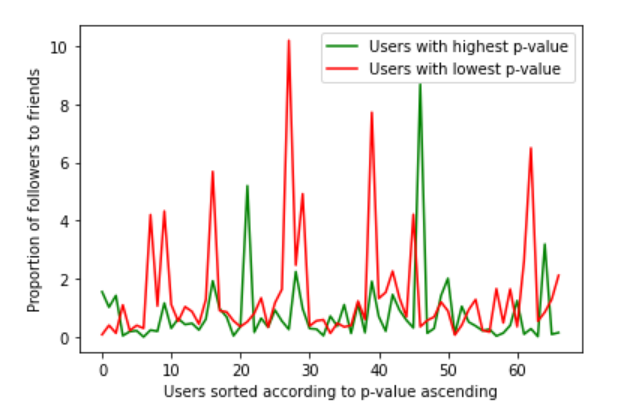